# Practical 7: Clustering and Association Mining

### In this practical
1. [Preparing data for clustering](#prep)
2. [Building your first K-means clustering](#clustering)
3. [Understanding and visualising your clustering model](#viz)
4. [Performing association mining](#apriori)
5. [Running and understanding results of association mining](#assoc)

---

This practical introduces you to clustering and association rules mining using Python. You will learn how to preprocess data for clustering/association, building clustering solutions and evaluate/visualise the results. Different from the algorithms/models introduced in the first half of the semester, the dataset used for clustering is **unlabelled** and the dataset for association mining is **transactional**. These datasets do not have the label information that is mandatory in predictive data mining. 


## 1. Preparing data for clustering<a name="prep"></a>

We will be using the `Census2000` dataset, which contains the postal code-level summary of the 2000 United States Census. There are 7 variables in this dataset:
* `ID`: Postal code of the region
* `LOCX`: Region longitude
* `LOCY`: Region latitude
* `MEANHHSZ`: Average household size in the region
* `MEDHHINC`: Median household income in the region
* `REGDENS`: Region population density percentile (1=lowest density, 100 = highest density)
* `REGPOP`: Number of people in the region

Similar with past practicals, we will use `pandas` to load the data and perform data preprocessing.

In [1]:
import pandas as pd
import numpy as np

# not skipping empty values, to demonstrate data preprocessing steps later
df = pd.read_csv('datasets/census2000.csv', na_filter=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 7 columns):
ID          33178 non-null object
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     33178 non-null object
RegPop      33178 non-null int64
MedHHInc    33178 non-null int64
MeanHHSz    33178 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.8+ MB


From the `.info()` output, you should notice the `RegDens` variable type is set incorrectly. The output listed `RegDens` as object/categorical, while based on the dataset description given above, `RegDens` should be an interval/numerical variable. Run `.describe()` and `.value_counts()` on the Series to get more information.

In [2]:
# get more information from RegDens
print(df['RegDens'].describe())
print(df['RegDens'].value_counts())

count     33178
unique      101
top            
freq       1013
Name: RegDens, dtype: object
       1013
22      322
23      322
20      322
28      322
2       322
78      322
26      322
40      322
58      322
41      322
19      322
46      322
70      322
60      322
4       322
47      322
43      322
57      322
37      322
76      322
8       322
90      322
31      322
29      322
64      322
87      322
38      322
93      322
81      322
       ... 
6       321
80      321
24      321
100     321
18      321
3       321
89      321
33      321
83      321
86      321
50      321
1       321
68      321
39      321
56      321
42      321
62      321
12      321
45      321
15      321
65      321
77      321
21      321
48      321
30      321
27      321
92      321
74      321
71      321
36      321
Name: RegDens, Length: 101, dtype: int64


The output of these functions reveals the cause of the incorrect type, which is a number of empty strings in this Series. Replace them with `nan` to denote them as missing values and typecast the series into float data type.

In [3]:
# replace the empty strings in the series with nan and typecast to float
df['RegDens'] = df['RegDens'].replace('', np.nan).astype(float)

As we learned from week 2, visualisation is a great way to spot data problems within the dataset. Again, we will use `seaborn` and `matplotlib` for that purpose. Plot the distribution of the variables using `distplot`.

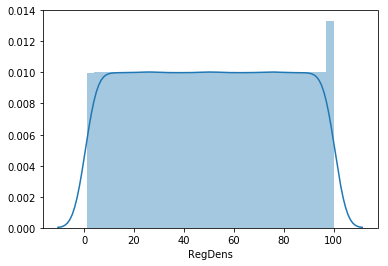

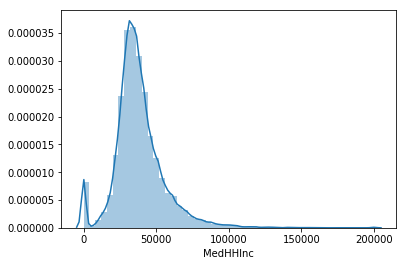

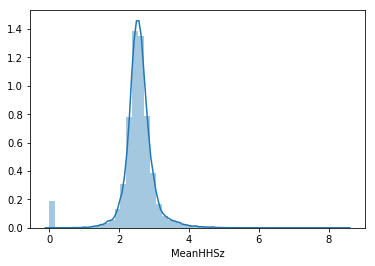

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of RegDens
regdens_dist = sns.distplot(df['RegDens'].dropna())
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df['MedHHInc'].dropna())
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna())

plt.show()

The last two distplots show anomalies in `MeanHHSz` and `MedHHInc`. For both of these variables, there is a large number of very low valued entries. Focus on `MeanHHSz` first. "Zoom in" on the distribution plot by increasing the number of bins.

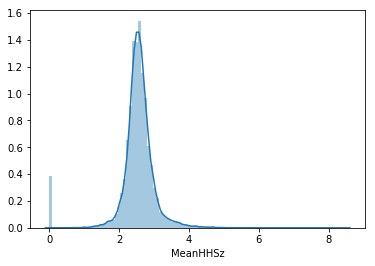

In [5]:
# Distribution of MeanHHSz, with increased number of bins. More bins = more specific distplot.
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna(), bins=100)
plt.show()

It is apparent that many of the records are valued close to zero, and logically it is unlikely for an household to have less than 1 member (need more than 1 person to build a family). This suggests a data problem with this variable. As mentioned before, `MedHHInc` also contains some errorneous values. There is a chance that these anomalies are related. We could explore this relation using FaceTGrid.

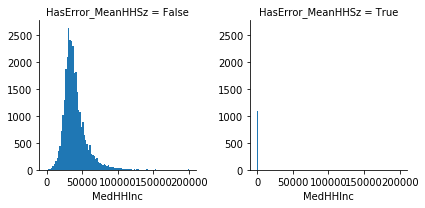

In [6]:
# create a mask of errorneous MeanHHSz values
df['HasError_MeanHHSz'] = df['MeanHHSz'] < 1

# use FaceTGrid to plot the distribution of MedHHInc when MeanHHSZ is errorneous
g = sns.FacetGrid(df, col='HasError_MeanHHSz')
g = g.map(plt.hist, 'MedHHInc', bins=100)

plt.show()

FacetGrid shows that errorneous data in `MeanHHSz` are correlated with errorneous data in `MedHHInc`. Based on this insight, we should eliminate all rows with errorneous `MeanHHSz`.

In [7]:
# before
print("Row # before dropping errorneous rows", len(df))

# a very easy way to drop rows with MeanHHSz values below 1
df = df[df['MeanHHSz'] >= 1]

# after
print("Row # after dropping errorneous rows", len(df))

Row # before dropping errorneous rows 33178
Row # after dropping errorneous rows 32079


Plot all three variables for final check.

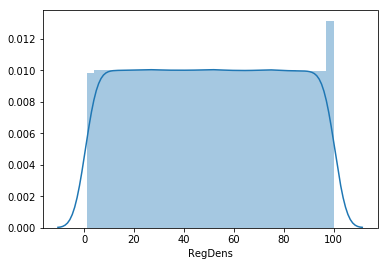

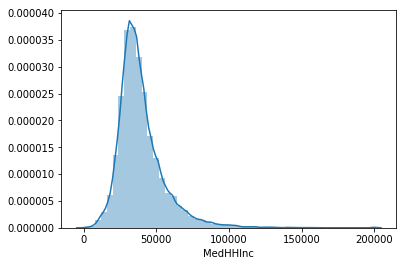

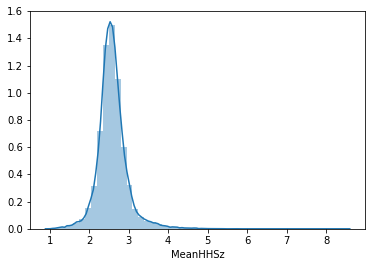

In [8]:
# Distribution of RegDens
regdens_dist = sns.distplot(df['RegDens'].dropna())
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df['MedHHInc'].dropna())
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna())

plt.show()

## 2. Building your first K-means clustering<a name="clustering"></a>

Once the data is cleaned, we are ready to build a clustering model. Before building the model, we should set the objective of this clustering process. There are a number of good grouping objectives to be applied in this dataset. These suburbs can be clustered based on location (`LocX` and `LocY`), demographic characteristic (`RegDens`, `MedHHInc`, `MeanHHSz` and `RegPop`) or both. As clustering suburbs based on geographical location is quite straightforward, we will focus on clustering based on demographic characteristics in this practical.

Thus, we will use `MedHHInc`, `MeanHHSz` and `RegDens` and drop the rest of the features. We will also drop `RegPop` as it provides overlapping information with `RegDens`. `RegPop` is also highly influenced by suburb area size, an information we do not have in this dataset. Therefore, to compare regions based on their demographic information accurately, `RegDens` is more suitable.

Similar with regression and neural network, clustering is also sensitive to inputs on different scale. Recall from the lecture that clustering uses **proximity/distance measure**. The most common distance measure is **eucledian distance**. With inputs on different scale, eucledian distance favors features on larger scale. Thus, we need to apply scaling before performing clustering.

In [9]:
from sklearn.preprocessing import StandardScaler

# take 3 variables and drop the rest
df2 = df[['MedHHInc', 'MeanHHSz', 'RegDens']]

# convert df2 to matrix
X = df2.as_matrix()

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

`sklearn` has many clustering solution implemented. In this practical, we will focus on the most common clustering, **K-Means**. As explained in the lecture, K-means starts by picking $k$ random points as the initial cluster centers (centroids). For each iteration of K-means, all data points are assigned to the closest centroids. Each centroids are then updated to get closer to the mean of each cluster.

In your project space/iPython console, start by importing the K-Means clustering. Initialise the clustering with `n_clusters` hyperparameter ($K$) of 3 and fit it to our dataset. Similar with many data mining models, K-Means clustering has the element of randomness, which is controlled by the `random_state` hyperparameter.

Remember, in clustering, we want to minimize the intra-cluster distance while maximizing the inter-cluster distances. After the model is fitted, print out its `inertia` (sum of distances of samples to their closest cluster center/centroid) and centroid locations.

In [10]:
from sklearn.cluster import KMeans

# random state, we will use 42 instead of 10 for a change
rs = 42

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 52450.3972844
Centroid locations:
[ 1.3217244   0.91717865  0.75575823]
[-0.41314661 -0.08345736 -0.88341817]
[-0.1745506  -0.4155335   0.83770386]


The number of clusters is controlled by the `n_clusters` hyperparameter. Higher $K$ will result in more centroids and clusters, which typically result in lower inertia and finer-grained, smaller clusters. Very high value of $K$, however, will create many small meaningless clusters.

In [11]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27714.1746375
Centroid locations:
[-0.19684355 -1.05386552  1.14618405]
[-0.23478461  0.51554832 -0.9314887 ]
[ 1.1156407   0.30939117  0.77186722]
[-0.3152316   3.24997527  0.1459049 ]
[-0.43415142  0.69278652  1.13724021]
[ 3.42065995  0.55990691  0.97283184]
[-0.57214942 -0.68438841 -1.19099911]
[-0.27564238 -0.16030974 -0.00113385]


## 3. Understanding and Visualising Your Clustering Model

We will take a closer look into our clustering model. A common method to understand our clustering results is to visualise the distribution of variables in our clusters. We have done this in a very limited way by printing the values of centroids.

To gain an even better view on how the clusters are spread out in the dataset, we could use seaborn's pairplot. Before that, we will use the trained clustering model to assign each record in our `X` with a cluster ID.

C:\Users\lieh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Cluster membership
1    15319
2    10584
0     6176
Name: Cluster_ID, dtype: int64


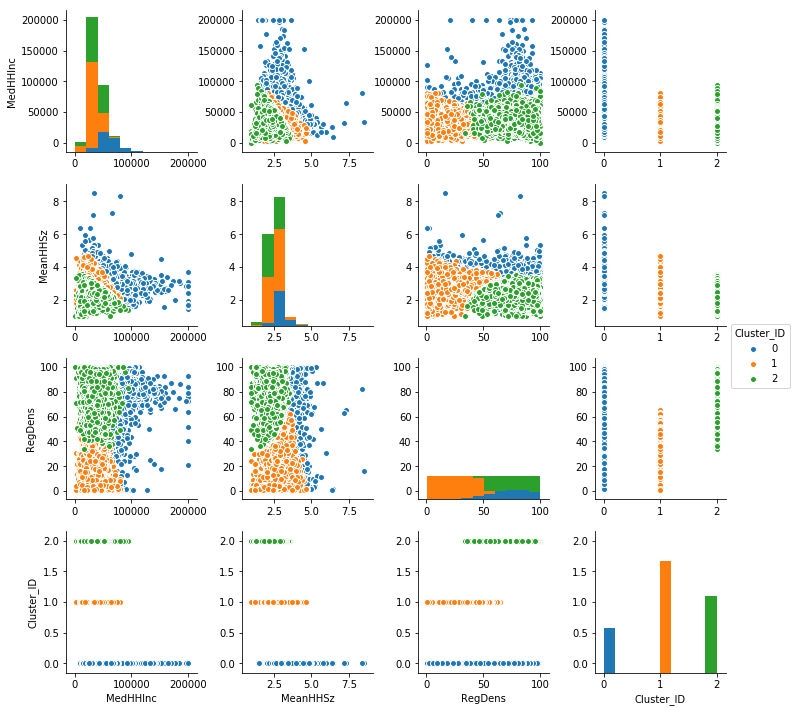

In [12]:
model = KMeans(n_clusters=3, random_state=rs).fit(X)

# assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df2['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

**Your clustering plots should look similar, but the cluster ID might not be similar. That is totally fine, not something that you can control even with `random_state`**

The pairplot shows us how different cluster members have different value distribution on different variables. Here is how to read it:
1. Take `MeanHHSz` distribution for example (second row, fourth column). Suburbs in cluster 0 are generally suburbs with average large households, while cluster 1 and 2 have the smaller ones.
2. Look at `MeanHHSz` and `RegDens` plot (second row, third column) and we could see the difference between suburbs in cluster 1 and 2. Cluster 1 covers less densely populated suburbs with smaller households, while cluster 2 covers more crowded regions and still small families.
3. For `MedHHInc` (first row, second column), pairplot shows that cluster 0 covering regions with higher median household.

Thus, we could profile the clusters as follow:
* Cluster 0: Suburbs with large households and medium-high earnings.
* Cluster 1: Sparse populated suburbs with smaller, low earning households.
* Cluster 2: Dense populated suburbs with smaller, low earning households.

While this PairPlot is useful to provide overall cluster profiles, it can get very cluttered and hard to understand once there are more clusters. In addition, you might only want to understand a specific cluster, therefore a PairPlot with all clusters might not be necessary.

Take the following clustering model with `k` = 8.

In [13]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27714.1746375
Centroid locations:
[-0.19684355 -1.05386552  1.14618405]
[-0.23478461  0.51554832 -0.9314887 ]
[ 1.1156407   0.30939117  0.77186722]
[-0.3152316   3.24997527  0.1459049 ]
[-0.43415142  0.69278652  1.13724021]
[ 3.42065995  0.55990691  0.97283184]
[-0.57214942 -0.68438841 -1.19099911]
[-0.27564238 -0.16030974 -0.00113385]


C:\Users\lieh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Cluster membership
7    7317
6    6231
1    5201
2    4889
0    3983
4    2458
5    1026
3     974
Name: Cluster_ID, dtype: int64


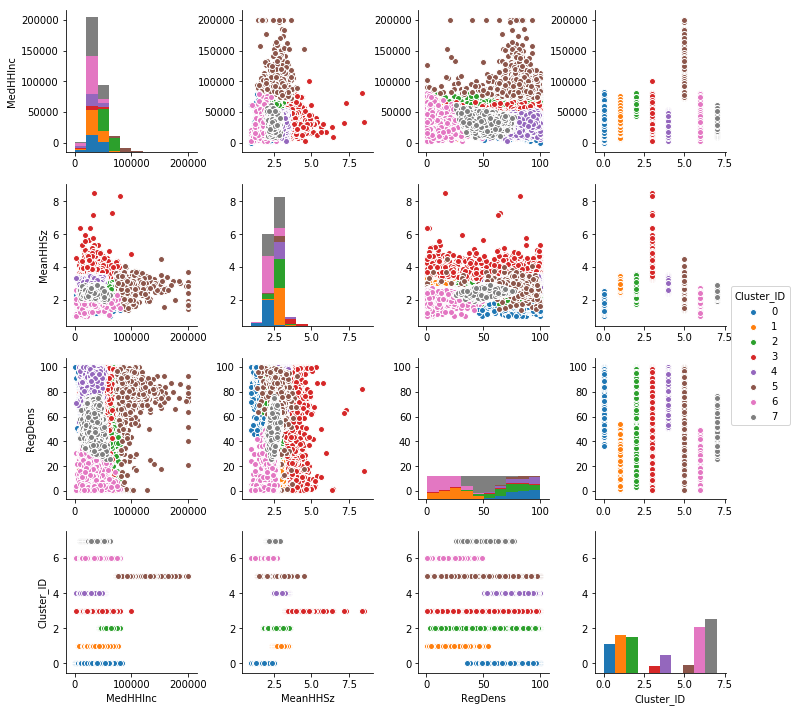

In [15]:
# again, ignore the warning
y = model.predict(X)
df2['Cluster_ID'] = y

# how many in each
print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

# pairplot
cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

As the number of clusters increases, the PairPlot becomes more specific, yet more confusing and difficult to interpret.

Assume you would like to get insights on cluster 0 and 1 from our $K=8$ K-Means clustering. An alternative way to profile them is to plot their respective variable distributions against the distributions from all data. This method shows certain characteristics from a cluster compared to characteristics of the whole dataset. Similar with practical 2, we will use `distplot` to visualise variable distribution. Use the following code:

Distribution for cluster 0


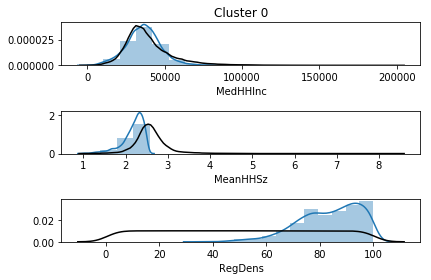

Distribution for cluster 1


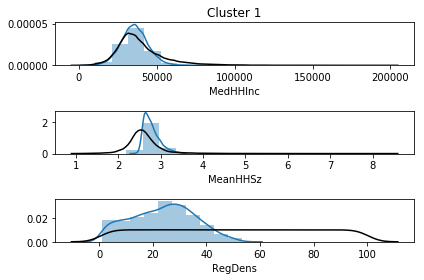

In [16]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['MedHHInc', 'MeanHHSz', 'RegDens']
n_bins = 20

# inspecting cluster 0 and 1
clusters_to_inspect = [0,1]

for cluster in clusters_to_inspect:
    # inspecting cluster 0
    print("Distribution for cluster {}".format(cluster))

    # create subplots
    fig, ax = plt.subplots(nrows=3)
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        # create the bins
        bins = np.linspace(min(df2[col]), max(df2[col]), 20)
        # plot distribution of the cluster using histogram
        sns.distplot(df2[df2['Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True)
        # plot the normal distribution with a black line
        sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")

    plt.tight_layout()
    plt.show()

** NOTE: Again, your cluster result should be the same, but the cluster IDs might not be.**

Here, we plot the distributions of cluster 0 and cluster 1 against the distributions from all data. The black lines are the distributions from all records, while light-blue lines are for a specific cluster. These plots show us the key characteristics of the clusters, as follows:
1. **Cluster 0:** Slightly higher `MedHHInc`, left leaning `MeanHHSz` and right leaning `RegDens`. Suburbs in cluster 0 are suburbs with small average household size and dense population.
2. **Cluster 1:** Slightly higher `MedHHInc`, right leaning `MeanHHSz` and left leaning `RegDens`. Showing that suburbs in cluster 1 are suburbs with above average median household income, large families and sparse population.

### 3.B. Determining $K$

As mentioned above, $K$ or the number of clusters is essential for your clustering building process. Smaller $K$ is easier/faster to train and should show the general groupings of the dataset. Larger $K$ result in finer-grained, more specific clusters, yet it is slow and could "overfit" the dataset. Therefore, the big question is, how do we determine the optimal $K$?

In many cases, $K$ can be derived from the business question we are trying to answer with clustering. For example, given a dataset of customers, we would like to build three different marketing approaches. Therefore, the logical answer is to set $K=3$, build the clusters and create your marketing plans based on the 3 segment profiles.

However, sometimes the business question does not provide clue to optimal $K$. For these cases, an alternative approach is to visually inspecting your data points. Unfortunately, if the dataset is quite large, you will soon find this approach is very ambiguous.

Therefore, we would like to introduce you to a widely used heuristic/rule-of-thumb, the **elbow method**. In this method, we need to compute the clustering error (in `sklearn` it is called `inertia`) for many values of $K$ (e.g. 2, 4, 6 etc). When you plot your $K$ values againsts the inertia, you should see both of them are negatively correlated (i.e. the error gets smaller once K gets larger). This is because as $K$ becomes larger, each cluster also becomes smaller, reducing the intra-cluster distances. The main idea of elbow method is to find K at which the error decreases abruptly. This produces an "elbow" effect around $K=8$ as you can see in the following picture. (Credit to this [quora answer](https://www.quora.com/How-can-we-choose-a-good-K-for-K-means-clustering))

![Elbow effect](https://qph.ec.quoracdn.net/main-qimg-678795190794dd4c071366c06bf32115-c)

In [17]:
# list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

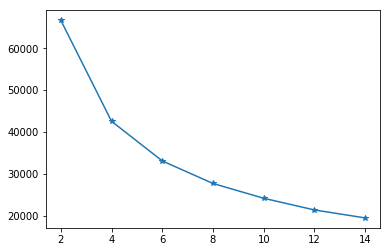

In [18]:
# plot the inertia vs K values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.show()

Here, the elbow is somewhere between 4 and 6. Either values can be selected for the optimal K.

While being a good heuristic, elbow method sometimes do not always yield the "obvious" K. In many cases, the error plot can be very smooth and shows no distinct K. As an alternative to this heuristic method, **silhouette score** is commonly used. Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

[More info on silhouette](https://en.wikipedia.org/wiki/Silhouette_%28clustering%29)

Assume you are considering between $K=4$ and $K=6$. We could use the `silhouette_score` from `sklearn`, which return mean silhouette score for all samples/records, to determine them. Just remember computing silhouette score is an expensive process, thus you need to be mindful in using the method.

In [19]:
from sklearn.metrics import silhouette_score

print(clusters[1])
print("Silhouette score for k=4", silhouette_score(X, clusters[1].predict(X)))

print(clusters[2])
print("Silhouette score for k=6", silhouette_score(X, clusters[2].predict(X)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=4 0.330932198489
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Silhouette score for k=6 0.253885773019


`silhouette_score` returns mean silhouette score of 0.33 for $K=4$ and 0.25 for $K=6$. This shows clusters in $K=4$ are more appropriately matched to its own cluster then $K=6$. Therefore, we could choose $K=4$ over $K=6$ on the basis of this score.

## 4. Performing Association Mining

In `bank.csv` dataset, a bank's marketing department is interested in examining associations between various retail banking services used by almost 8,000 customers. Marketing would like to determining both typical and atypical service combinations.

These requirements suggest association mining - in particular a market basket analysis. Data for this problem is usually consisted of two variables, **transaction** ID and **items**. For each transaction, there is a list of items. For our banking dataset, a transaction is an individual customer account, and items are products bought by each customer. An association rule is a statement of the form (item set A) => (item set B).

Recall from the lecture that association rules are typically built with **apriori algorithm**. Unfortunately, `sklearn` does not provide any implementation of Apriori algorithm. Therefore, we will install and use a library called `apyori` for this task.

Open your Anaconda prompt and install the library using this command:

```bash
pip install apyori
```

Once the library is installed, we need to perform some data preprocessing on the `bank` dataset. Firstly, load the data set using pandas.

In [20]:
import pandas as pd

# load the bank transaction dataset
df = pd.read_csv('datasets/bank.csv')

# info and the first 10 transactions
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32367 entries, 0 to 32366
Data columns (total 3 columns):
ACCOUNT    32367 non-null int64
SERVICE    32367 non-null object
VISIT      32367 non-null int64
dtypes: int64(2), object(1)
memory usage: 758.7+ KB
None
   ACCOUNT SERVICE  VISIT
0   500026   CKING      1
1   500026     SVG      2
2   500026     ATM      3
3   500026     ATM      4
4   500075   CKING      1
5   500075    MMDA      2
6   500075     SVG      3
7   500075     ATM      4
8   500075   TRUST      5
9   500075   TRUST      6


The BANK data set contains service information for nearly 8,000 customers. There are three variables in the data set:
1. ACCOUNT: Account number, nominal
2. SERVICE: Type of service, nominal
3. VISIT: Order of product purchased, ordinal

The BANK data set has over 32,000 rows. Each row of the data set represents a customer-service combination. Therefore, a single customer can have multiple rows in the data set, and each row represents one of the products he or she owns. The median number of products per customer is three. The 13 products are represented in the data set using the following abbreviations:
* ATM - automated teller machine debit card
* AUTO automobile installment loan
* CCRD credit card
* CD certificate of deposit
* CKCRD check/debit card
* CKING checking account
* HMEQLC home equity line of credit
* IRA individual retirement account
* MMDA money market deposit account
* MTG mortgage
* PLOAN personal/consumer installment loan
* SVG saving account
* TRUST personal trust account

As we are looking to generate association rules from items purchased by each account holder, we need to group our accounts and then generate list of all services purchased.

In [21]:
# group by account, then list all services
transactions = df.groupby(['ACCOUNT'])['SERVICE'].apply(list)

print(transactions.head(5))

ACCOUNT
500026                   [CKING, SVG, ATM, ATM]
500075    [CKING, MMDA, SVG, ATM, TRUST, TRUST]
500129              [CKING, SVG, IRA, ATM, ATM]
500256               [CKING, SVG, CKCRD, CKCRD]
500341               [CKING, SVG, CKCRD, CKCRD]
Name: SERVICE, dtype: object


Once the `transactions` table contains all services purchased by each account number, we are ready to build our association rules. `apyori`'s `apriori` function accepts a number of arguments, mainly:
1. `transactions`: list of list of items in transactions (eg. [['A', 'B'], ['B', 'C']]).
2. `min_support`: Minimum support of relations in float percentage. Default 0.1.
3. `min_confidence`: Minimum confidence of relations in float percentage. Default 0.0.
4. `min_lift`: Minimum lift of relations in float percentage. Default 0.0.
5. `max_length`: Max length of the relations. Default None.

We will run our `apyori` model with our transactions and min_support of 0.05.

In [23]:
from apyori import apriori

# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)
results = list(apriori(transaction_list, min_support=0.05))

# print first 5 rules
print(results[:5])

[RelationRecord(items=frozenset({'ATM'}), support=0.3845576273307471, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'ATM'}), confidence=0.3845576273307471, lift=1.0)]), RelationRecord(items=frozenset({'AUTO'}), support=0.09285446126892755, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'AUTO'}), confidence=0.09285446126892755, lift=1.0)]), RelationRecord(items=frozenset({'CCRD'}), support=0.154799149042673, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'CCRD'}), confidence=0.154799149042673, lift=1.0)]), RelationRecord(items=frozenset({'CD'}), support=0.24527593542735576, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'CD'}), confidence=0.24527593542735576, lift=1.0)]), RelationRecord(items=frozenset({'CKCRD'}), support=0.11300212739331748, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'CKCRD'}), confidence=0.1

The output might look very cluttered. Thus, I have provided the following function to help you printing it out. We will not go deeper to explain how it works and it is not essential for your learning objective, but we have included some comments to help you out.

In [24]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)

print(result_df.head(20))

   Left_side Right_side   Support  Confidence      Lift
0                   ATM  0.384558    0.384558  1.000000
1                  AUTO  0.092854    0.092854  1.000000
2                  CCRD  0.154799    0.154799  1.000000
3                    CD  0.245276    0.245276  1.000000
4                 CKCRD  0.113002    0.113002  1.000000
5                 CKING  0.857840    0.857840  1.000000
6                HMEQLC  0.164685    0.164685  1.000000
7                   IRA  0.108372    0.108372  1.000000
8                  MMDA  0.174446    0.174446  1.000000
9                   MTG  0.074334    0.074334  1.000000
10                  SVG  0.618696    0.618696  1.000000
11       ATM         CD  0.071581    0.186137  0.758889
12        CD        ATM  0.071581    0.291837  0.758889
13       ATM      CKING  0.361907    0.941100  1.097058
14     CKING        ATM  0.361907    0.421882  1.097058
15       ATM     HMEQLC  0.085346    0.221933  1.347619
16    HMEQLC        ATM  0.085346    0.518237  1

The table contains statistics of support, condence and lift for each of the rules.

Consider the rule A ⇒ B. Recall the following concepts from lecture:
* Support of A ⇒ B is the probability that a customer has both A and B.
* Confidence of A ⇒ B is the probability that a customer has B given that the customer has A.
* Expected confidence (not shown here) of A ⇒ B is the probability that a customer has B.
* Lift of A ⇒ B is a measure of strength of the association. If Lift=2 for the rule A=>B, then a customer having A is twice as likely to have B than a customer chosen at random. Lift is the confidence divided by expected confidence.

In a typical setting, we would like to view the rules by lift value. Sort the rules using code below:

In [25]:
# sort all acquired rules descending by lift
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(10))

            Left_side Right_side   Support  Confidence      Lift
79         CKING,CCRD      CKCRD  0.055813    0.375737  3.325045
25               CCRD      CKCRD  0.055813    0.360550  3.190645
80        CKING,CKCRD       CCRD  0.055813    0.493909  3.190645
26              CKCRD       CCRD  0.055813    0.493909  3.190645
104     ATM,CKING,SVG     HMEQLC  0.060944    0.245217  1.489001
73            ATM,SVG     HMEQLC  0.060944    0.237214  1.440407
63          ATM,CKING     HMEQLC  0.085346    0.235823  1.431961
74         SVG,HMEQLC        ATM  0.060944    0.546577  1.421313
106  CKING,SVG,HMEQLC        ATM  0.060944    0.546577  1.421313
65       CKING,HMEQLC        ATM  0.085346    0.518237  1.347619


The highest lift rule is *checking*, and *credit card* implies *check card*. This is not surprising given that many check cards include credit card logos.

## End Notes and Next Week

This week, we learned how to build, tune and explore clustering models. We also visualisation technique to help us explain the cluster/segment profiles produced by the model. In addition, we also built association mining model using `apyori` library and explored the rules produced by it.

Next week, we will introduce you to text mining.